- 본 프로젝트는 item의 Ranking feature가 GCN based model에서 유효한 변수인지를 확인하는 것이 목표입니다. 유효하다는 의미는, GCN based model을 사용하여 추천시스템을 만들 계획인데, Ranking을 사용하는 것이 추천을 할 때 성능향상을 이끌어낼 수 있을 것인지를 확인해보자는 뜻입니다. Model 구조의 개선보다는 Data specific한 해결책을 강구한 내용입니다.

- model은 이전에 설명했던 LR-GCCF를 사용할 예정입니다.

>epoch: 69 time: 108.2s	 train loss: 0.2294 test loss:0.2288

>epoch: 70 time: 124.5s	 train loss: 0.2294 test loss:0.2287

>epoch: 71 time: 106.9s	 train loss: 0.2292 test loss:0.2291

- 총 350번의 epoch으로 training을 했습니다만 가장 test loss가 적은 것은 70 epoch까지 학습을 진행했을 때이므로, 이때의 embedding으로 ranking verification을 진행하겠습니다.

In [1]:
# Model load
import torch

model = torch.load('./result/LRGCCF_amazon_books_2018/training_result/epoch70.pt')

In [2]:
# topk item recommendation
def topk_count(model, k):
    topk_ranking_dict = {}
    for user in model['embed_user.weight']:
        topk = torch.topk(torch.inner(user, model['embed_item.weight']), k)
        for i in topk.indices:
            int_i = int(i)
            if int_i not in topk_ranking_dict:
                topk_ranking_dict[int_i] = 1
            else:
                topk_ranking_dict[int_i] += 1
                
    return topk_ranking_dict

top20_ranking_dict = topk_count(model, 20)

 - user에게 item을 추천해주기 위해서는, 한 user i의 vector를 모든 item들의 vector들과 inner product을 진행한 후 가장 값이 큰 n개를 추천해줍니다. n은 20을 사용할 예정입니다.
 - 지금 사용하는 data는 item이 그렇게 많지 않아(약 16만개) 기본적인 함수인 ```torch.inner()```와 ```torch.topk()``` function을 사용하여 inner product값을 비교하지만, large scale data에서 사용하기엔 속도가 느리다고 합니다. 이 project를 정리하는 시점에 vector similarity를 효율적으로 계산해주는 facebook에서 만든 faiss라는 library를 알게 되었습니다. data의 양이 조금 더 커진다면 해당 library를 사용하여 추천과정에서 시간을 조금 더 단축시킬 수 있을 것 같습니다.

- 본격적으로 ranking value를 가공하여 recommendation에 적용하여 성능개선을 확인해보기 전에, ranking이 유효할 것인지 간접적으로 확인해봅시다. ranking이 유효하려면, 다시말해서 추천시스템의 성능이 개선되려면 기존에 inner product 값이 상위 20개 안에는 못 들었으나 user가 rating을 했던 item이(놓친 정답 item), ranking을 transform한 값을 더하여 상위 20개 안에 진입해야합니다. ranking을 transoform한 값은 적절한 weight을 곱해 inner product값에 더해줄 예정이지만, weight을 hyperparameter로서 적당히 조절해나가다보면 영향력이 제한될 것입니다. 이때 ranking이 유효하기 위해서는 저런 '놓친 정답 item'들이 inner product값이 상위 20개 안에는 못 들지만 적당히 상위권에 위치하고, ranking도 높아야 할 것입니다. 적당한 상위권으로 top100에 들어본 적 있는 item까지 조사해보겠습니다.

In [3]:
import numpy as np

ranking_list = np.load('./data/ranking_list.npy', allow_pickle = True)
ranking_list = list(map(int, ranking_list))
print('Min ranking: ', min(ranking_list), '\nMax ranking: ', format(max(ranking_list), ','))

Min ranking:  2 
Max ranking:  21,639,937


- 최솟값과 최댓값을 확인해본 결과 ranking은 2에서부터 약 2100만까지 광범위하게 있습니다. 값의 range가 상당히 광범위하기 때문에 밑이 10인 log transformation을 취해봅시다.

(array([2., 0., 0., ..., 3., 2., 1.]),
 array([0.30103   , 0.30173342, 0.30243684, ..., 7.33384915, 7.33455257,
        7.33525599]),
 <BarContainer object of 10000 artists>)

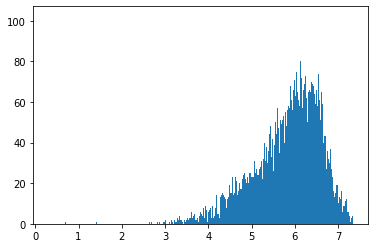

In [4]:
import math
import matplotlib.pyplot as plt

ranking_list_log = list(map(math.log10, ranking_list))
plt.hist(ranking_list_log, bins = 10000)

- log transformation을 한 값을 histogram으로 표현해보면 위와 같은 그래프가 나옵니다. 밑이 10인 log transformation을 해주었기에 0 ~ 1 구간은 (1 ~ 9), 1 ~ 2 구간은 (10 ~ 99), 2 ~ 3 구간은 (100 ~ 999) $\cdots$ 6~7 구간은 (1,000,000 ~ 9,999,999)의 범위의 값들이 존재할 수 있으므로, 위와 같이 오른쪽으로 갈수록 많은 값들이 몰려있는 모양(right skewed)이 나옵니다.

(array([1., 0., 0., ..., 0., 1., 3.]),
 array([0.60205999, 0.60273322, 0.60340644, ..., 7.33295958, 7.3336328 ,
        7.33430603]),
 <BarContainer object of 10000 artists>)

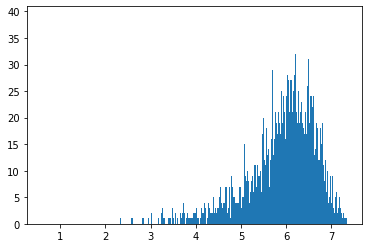

In [5]:
top20_ranking_list_log = [ranking_list_log[i] for i in list(top20_ranking_dict.keys())]
plt.hist(top20_ranking_list_log, bins = 10000)

- 한 user에게라도 inner product 값이 top20에 들어, 추천이 된 적 있는 item들의 ranking을 log transformation한 다음 histogram으로 나타내보았습니다.

(array([1., 0., 0., ..., 3., 2., 1.]),
 array([0.30103   , 0.30173342, 0.30243684, ..., 7.33384915, 7.33455257,
        7.33525599]),
 <BarContainer object of 10000 artists>)

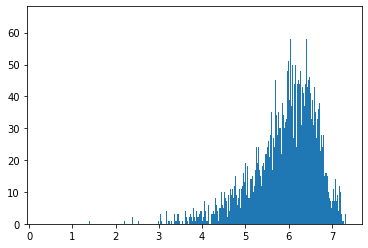

In [6]:
top100_ranking_dict = topk_count(model, 100)
top100_ranking_list_log = [ranking_list_log[i] for i in list(top100_ranking_dict.keys())]
plt.hist(top100_ranking_list_log, bins = 10000)

- 한 user에게라도 inner product값이 top100에 들어, 추천이 된 적 있는 item들의 ranking을 log transformation한 다음 histogram으로 나타내보았습니다.
- top20과 top100의 들어본 적 있는 item들의 histogram을 살펴본 결과, 전체 ranking value를 log transformation하여 만든 histogram의 모습과 별 차이가 없어보입니다.

In [7]:
from collections import Counter

original_scale_count = list(map(math.ceil, ranking_list_log))
original_scale_count = sorted(Counter(original_scale_count).items())

top20_scale_count = list(map(math.ceil, top20_ranking_list_log))
top20_scale_count = sorted(Counter(top20_scale_count).items())

top100_scale_count = list(map(math.ceil, top100_ranking_list_log))
top100_scale_count = sorted(Counter(top100_scale_count).items())

In [8]:
original_length = len(ranking_list_log)
top20_length = len(top20_ranking_list_log)
top100_length = len(top100_ranking_list_log)
for i in range(8):
    print('scale: {0},'.format(i+1), 'original: {0:5f}'.format(original_scale_count[i][1]/original_length),\
          'top100: {0:5f}'.format(top100_scale_count[i][1]/top100_length),\
          'top20: {0:5f}'.format(top20_scale_count[i][1]/top20_length))

scale: 1, original: 0.000037 top100: 0.000032 top20: 0.000018
scale: 2, original: 0.000249 top100: 0.000317 top20: 0.000452
scale: 3, original: 0.002158 top100: 0.002356 top20: 0.002980
scale: 4, original: 0.019589 top100: 0.018534 top20: 0.020699
scale: 5, original: 0.129117 top100: 0.109663 top20: 0.108153
scale: 6, original: 0.380043 top100: 0.359286 top20: 0.354477
scale: 7, original: 0.445426 top100: 0.482168 top20: 0.484250
scale: 8, original: 0.023382 top100: 0.027643 top20: 0.028971


- log transformation한 값들을 올림하여 비율로 나타내었을 때 위와 같은 수치를 보였습니다. scale은 10의 n승 미만의 숫자들을 의미합니다. E.g.) scale이 1일 경우는 10^1인 10 미만의 수들의 비율입니다. scale이 1인 경우는 워낙 해당되는 경우가 적어(전체 item 중 10개 미만) 이를 제외하고 보면, scale 2, 3, 4 구간의 경우(ranking 값이 10 ~ 9,999인 item들) 전체 item보다는 top100에 들어본 적이 있는 item, top100에 들어본 적 있는 item보단 top20에 들어본 적 있는 item의 비율이 더 높다는 것을 알 수 있었습니다.
- 하지만 이는 상대적으로 ranking이 높은(숫자는 낮은)값의 비율이 조금 더 많다는 것이지, 전체에서의 비중을 살펴보면 여전히 기껏해야 2% 남짓밖에 되지 않는 비율입니다. 그렇기에 ranking을 사용할 경우 성능의 증가는 있겠지만 큰 폭의 향상이 있진 않을 것이라 추측됩니다.

- 이제 ranking을 사용하여 recommender system의 성능향상이 되는지 metric으로 측정해보겠습니다.

In [9]:
def reciprocal(x):
    return 1/x

ranking_list_log_rec = list(map(reciprocal, ranking_list_log))

- Ranking이 높다는 것은 ranking 숫자는 낮다는 것을 의미하므로, ranking이 높은 item들이 더 잘 추천되도록 만들려면 Log transformation을 취해준 값에 역수를 취하여 사용하여야 합니다. 이를 상위 20개의 model을 추천할 때 적절한 weight값을 곱하여 inner product값에 더해주는 방식을 취하려고 합니다.

In [10]:
GPU_NUM = 7
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else "cpu")
ranking_list_log_rec_tensor = torch.tensor(ranking_list_log_rec).to(device)

In [11]:
def top20_ranking(model, ranking_list_log_rec_tensor, weight):
    top20_indices = []
    for user in model['embed_user.weight']:
        scores = torch.inner(user, model['embed_item.weight'])
        score_max = scores.max()
        score_min = scores.min()

        scaled_ranking = weight * (ranking_list_log_rec_tensor - score_min)/(score_max - score_min)
        indices = torch.topk(scores + scaled_ranking, 20).indices.cpu().detach().numpy()
        top20_indices.append(indices)
        
    return top20_indices

In [12]:
top20_original = top20_ranking(model, ranking_list_log_rec_tensor, weight = 0)
top20_10 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 10)
top20_1 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 1)
top20_minus1 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 0.1)
top20_minus2 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 0.01)
top20_minus3 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 0.001)

- 각 user마다 inner product값의 편차가 심합니다. 그래서 각 user마다 inner product값의 최댓값과 최솟값으로 ranking의 transformation 값을 min-max scaling하여 더해주고, 이를 토대로 다시 상위 20개의 item들을 추출해냅니다.
- min-max scaling해준 값에 weight을 곱한 다음 inner product값에 더해주는데, 이때 weight값을 조절해줌으로써 ranking의 영향력을 조절할 수 있습니다. weight이 0일 경우 ranking을 사용하지 않는다는 의미이며, 0.001 ~ 10까지 10의 n승 scale로 올려주면서 새로운 상위 20개의 item추천을 하였습니다.

- 성능평가에는 Recall과 NDCG(Normalized Discounted Cumulative Gain)를 사용할 예정입니다. NDCG는 recommender model 평가에 자주 사용되는 metric입니다. Recall이 실제 user가 구매(혹은 평가)한 item 중 추천한 n개의 item이 몇개나 포함되는지로 평가된다면, NDCG는 그 item들(실제 구매도 했고 추천도 된 item들)의 추천순서를 평가합니다. NDCG는 Recall과 달리 추천된 item이 실제 user가 구매(혹은 평가)한 item이더라도, 해당 item들을 추천한 item들 중 높은 우선순위로 추천하지 않으면 성능이 낮게 측정됩니다. 추천된 item이 user와 관련있는 정도에 따라 relation value를 부여받고, 추천된 순위에 따라 후순위로 갈수록 값이 작아지게 되고(Discounted), 이를 누적시켜(Cumulative) 더한 다음, 이상적인 DCG값(Ideal DCG)으로 정규화(Normalize)합니다. 본 프로젝트에서는 유저가 실제 rating을 한 item들은 relation value를 일괄적으로 1로 부여했습니다.(ranking의 유효성을 검증하기 위한 목적이므로 1로만 부여해도 무관합니다.)
- Recall과 NDCG 둘 다 높을수록 좋은 성능을 의미합니다.

In [13]:
data_base_path = './data'
testing_user_set, testing_item_set, testing_set_count = np.load(data_base_path + '/testing_set.npy', allow_pickle=True)  

In [14]:
def recall(top20_ranking_indices, testing_user_set, round_num):
    recall_storage = []
    for j in range(len(top20_ranking_indices)):
        if len(testing_user_set[j]) == 0:
            continue
        count = 0
        for i in testing_user_set[j]:
            if i in top20_ranking_indices[j]:
                count += 1
        recall_temp = count / len(testing_user_set[j])
        recall_storage.append(recall_temp)

    np_recall_storage = np.array(recall_storage)
    return round(np_recall_storage.mean(), round_num)

In [15]:
recall_original = recall(top20_original, testing_user_set, 7)
recall_10 = recall(top20_10, testing_user_set, 7)
recall_1 = recall(top20_1, testing_user_set, 7)
recall_minus1 = recall(top20_minus1, testing_user_set, 7)
recall_minus2 = recall(top20_minus2, testing_user_set, 7)
recall_minus3 = recall(top20_minus3, testing_user_set, 7)

In [16]:
def NDCG(top20_ranking_indices, testing_user_set, round_num):
    NDCG_storage = []
    for j in range(len(top20_ranking_indices)):
        if len(testing_user_set[j]) == 0:
            continue
            
        temp_NDCG = [] 
        if len(top20_ranking_indices[j]) >= 20:
            idcg = sum((1.0/np.log(i+1) for i in range(1, 21)))
        else:
            idcg = sum((1.0/np.log(i+1) for i in range(1, len(top20_ranking_indices[j])+1)))

        for i in testing_user_set[j]:
            if i in top20_ranking_indices[j]:
                temp_NDCG.append(1.0 / np.log(np.where(top20_ranking_indices[j] == i)[0][0]+1 + 1))

        NDCG_sub = sum(temp_NDCG) / idcg
        NDCG_storage.append(NDCG_sub)

    np_NDCG_storage = np.array(NDCG_storage)
    return round(np_NDCG_storage.mean(), round_num)

In [17]:
NDCG_original = NDCG(top20_original, testing_user_set, 7)
NDCG_10 = NDCG(top20_10, testing_user_set, 7)
NDCG_1 = NDCG(top20_1, testing_user_set, 7)
NDCG_minus1 = NDCG(top20_minus1, testing_user_set, 7)
NDCG_minus2 = NDCG(top20_minus2, testing_user_set, 7)
NDCG_minus3 = NDCG(top20_minus3, testing_user_set, 7)

In [18]:
print('Recall\n{0:07f}: original\n{1:07f}: weight 10\n{2:07f}: weight 1\n{3:07f}: weight 0.1\n{4:07f}: weight 0.01\n{5:07f}: weight 0.001'\
      .format(recall_original, recall_10, recall_1, recall_minus1, recall_minus2, recall_minus3))

Recall
0.012003: original
0.006501: weight 10
0.011955: weight 1
0.012018: weight 0.1
0.012004: weight 0.01
0.012004: weight 0.001


In [19]:
print('NDCG\n{0:07f}: original\n{1:07f}: weight 10\n{2:07f}: weight 1\n{3:07f}: weight 0.1\n{4:07f}: weight 0.01\n{5:07f}: weight 0.001'\
      .format(NDCG_original, NDCG_10, NDCG_1, NDCG_minus1, NDCG_minus2, NDCG_minus3))

NDCG
0.011658: original
0.003598: weight 10
0.011055: weight 1
0.011664: weight 0.1
0.011659: weight 0.01
0.011658: weight 0.001


- Recall과 NDCG, 두 성능평가 metric 모두 weight을 0.1을 사용하였을 때 가장 성능이 높았습니다. 하지만 초반에 ranking의 유효성에 대해 추측했던 것처럼 엄청난 성능의 향상은 없었고 미약한 개선이 이루어졌습니다. 

In [20]:
top20_dot5 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 0.5)
top20_dot05 = top20_ranking(model, ranking_list_log_rec_tensor, weight = 0.05)

recall_dot5 = recall(top20_dot5, testing_user_set, 7)
recall_dot05 = recall(top20_dot05, testing_user_set, 7)
NDCG_dot5 = NDCG(top20_dot5, testing_user_set, 7)
NDCG_dot05 = NDCG(top20_dot05, testing_user_set, 7)

In [21]:
print('Recall\n{0:07f}: original\n{1:07f}: weight 0.5\n{2:07f}: weight 0.1\n{3:07f}: weight 0.05\n'\
      .format(recall_original, recall_dot5, recall_minus1, recall_dot05))
print('NDCG\n{0:07f}: original\n{1:07f}: weight 0.5\n{2:07f}: weight 0.1\n{3:07f}: weight 0.05'\
      .format(NDCG_original, NDCG_dot5, NDCG_minus1, NDCG_dot05))

Recall
0.012003: original
0.012027: weight 0.5
0.012018: weight 0.1
0.012006: weight 0.05

NDCG
0.011658: original
0.011529: weight 0.5
0.011664: weight 0.1
0.011660: weight 0.05


- weight 중 가장 높은 성능을 보여준 0.1을 기준으로 0.5와 0.05를 추가로 탐색해본 결과, 0.5를 사용했을 때 recall이 조금 더 나아지긴 했지만 NDCG는 조금 더 내려갑니다. 하지만 Recall의 상승폭(+0.00009)보단 NDCG의 하락폭(-0.000135)이 더 컸기에 weight은 약 0.1에서 최적화된 값을 가진다고 추측해볼 수 있습니다.